In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import RMSprop
from rbf_layer import RBFLayer, InitCentersRandom
import matplotlib.pyplot as plt

In [2]:
def roll_beta(window_size, stock, market):
    data = {'X': market, 'Y': stock}
    df = pd.DataFrame(data)
    cov = df.X.rolling(window=window_size).cov(df.Y)
    var = df.X.rolling(window=window_size).var()
    roling_beta = cov/var
    return np.array(roling_beta[window_size - 1:])

In [3]:
def return_from_stock(stock_data):
    stock = pd.read_csv(f"{stock_data}")
    #creating new column 'return' it is percentage change between current and last month close price
    stock['return'] = stock.Zamkniecie.pct_change()
    return np.array(stock['return'][1:]) # first value is NaN so [1:]

In [4]:
wig_20_return = return_from_stock('wig20_m.csv')
peo_return = return_from_stock('peo_m.csv')

In [5]:
peo_roll_beta = roll_beta(36, peo_return, wig_20_return)

In [6]:
peo_roll_beta

array([0.9772635 , 0.97014216, 1.00021326, 1.00341387, 0.99066662,
       1.00436244, 0.99490991, 1.02171093, 1.03098369, 1.03367474,
       1.051477  , 1.0441973 , 1.06097197, 1.06000448, 1.03501676,
       1.04392938, 1.05036511, 1.06179624, 1.04459305, 1.05446398,
       1.04846115, 1.0680065 , 1.07123908, 1.07525705, 1.06774364,
       1.08922898, 1.13356561, 1.12231121, 1.11750739, 1.11221958,
       1.11222089, 1.15435166, 1.18812062, 1.26028061, 1.23078474,
       1.43892495, 1.44945814, 1.44257389, 1.49245589, 1.48736234,
       1.48676661, 1.49808716, 1.51245944, 1.49931122, 1.49980717,
       1.5056696 , 1.46281084, 1.46229541, 1.45473297, 1.45703139,
       1.42105982, 1.42173266, 1.42370527, 1.43551197, 1.44929252,
       1.42299995, 1.45985696, 1.45545443, 1.44527129, 1.4413922 ,
       1.44229289, 1.45366658, 1.43358319, 1.40905135, 1.40282212,
       1.47843879, 1.45342916, 1.42107272, 1.42991674, 1.33643484,
       1.37197186, 1.06860085, 1.05577774, 1.06599178, 0.92549

In [7]:
# creating training dataset
df_data = pd.DataFrame({
    'target': peo_roll_beta,
    't-1': np.roll(peo_roll_beta, 1),
    't-2': np.roll(peo_roll_beta, 2),
    't-3': np.roll(peo_roll_beta, 3),
    't-4': np.roll(peo_roll_beta, 4),
    't-5': np.roll(peo_roll_beta, 5)
})
df_data = df_data.iloc[5:]

In [8]:
df_data

,target,t-1,t-2,t-3,t-4,t-5
5,1.004362,0.990667,1.003414,1.000213,0.970142,0.977263
6,0.994910,1.004362,0.990667,1.003414,1.000213,0.970142
7,1.021711,0.994910,1.004362,0.990667,1.003414,1.000213
8,1.030984,1.021711,0.994910,1.004362,0.990667,1.003414
9,1.033675,1.030984,1.021711,0.994910,1.004362,0.990667
...,...,...,...,...,...,...
200,1.320562,1.322314,1.325707,1.396829,1.325983,1.353047
201,1.368290,1.320562,1.322314,1.325707,1.396829,1.325983
202,1.234932,1.368290,1.320562,1.322314,1.325707,1.396829
203,1.314584,1.234932,1.368290,1.320562,1.322314,1.325707


In [9]:
X = df_data.iloc[:, -5:]
X

,t-1,t-2,t-3,t-4,t-5
5,0.990667,1.003414,1.000213,0.970142,0.977263
6,1.004362,0.990667,1.003414,1.000213,0.970142
7,0.994910,1.004362,0.990667,1.003414,1.000213
8,1.021711,0.994910,1.004362,0.990667,1.003414
9,1.030984,1.021711,0.994910,1.004362,0.990667
...,...,...,...,...,...
200,1.322314,1.325707,1.396829,1.325983,1.353047
201,1.320562,1.322314,1.325707,1.396829,1.325983
202,1.368290,1.320562,1.322314,1.325707,1.396829
203,1.234932,1.368290,1.320562,1.322314,1.325707


In [10]:
y = df_data.target
y

5      1.004362
6      0.994910
7      1.021711
8      1.030984
9      1.033675
         ...   
200    1.320562
201    1.368290
202    1.234932
203    1.314584
204    1.327663
Name: target, Length: 200, dtype: float64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

Bulding network model

In [12]:
model = Sequential()
rbflayer = RBFLayer(10,
                    initializer=InitCentersRandom(X_train),
                    betas=2.0,
                    input_shape=(5,))
model.add(rbflayer)
model.add(Dense(1))

model.compile(loss='mean_squared_error',
              optimizer=RMSprop())

model.fit(X_train, y_train,
          batch_size=10,
          epochs=200,
          verbose=1)

Epoch 1/200
16/16 [==============================] - 1s 4ms/step - loss: 0.5789
Epoch 2/200
16/16 [==============================] - 0s 2ms/step - loss: 0.4324
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.3406
Epoch 4/200
16/16 [==============================] - 0s 3ms/step - loss: 0.2692
Epoch 5/200
16/16 [==============================] - 0s 3ms/step - loss: 0.2121
Epoch 6/200
16/16 [==============================] - 0s 4ms/step - loss: 0.1639
Epoch 7/200
16/16 [==============================] - 0s 4ms/step - loss: 0.1238
Epoch 8/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0919
Epoch 9/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0668
Epoch 10/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0481
Epoch 11/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0358
Epoch 12/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0277
Epoch 13/200
16/16 [=================

In [13]:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 0s/step


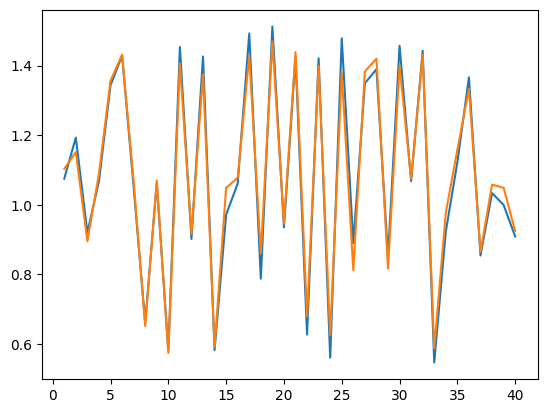

In [18]:
x = np.arange(1, len(y_pred) + 1)
plt.plot(x,y_test)
plt.plot(x,y_pred)
plt.show()

5/5 [==============================] - 0s 4ms/step


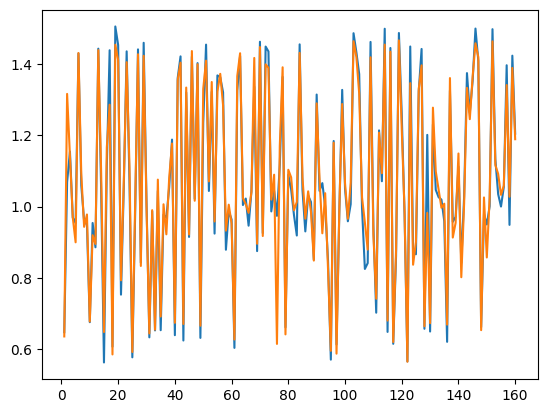

In [19]:
y_pred = model.predict(X_train)
x = np.arange(1, len(y_pred) + 1)
plt.plot(x,y_train)
plt.plot(x,y_pred)
plt.show()